# Use a ARIMA model to predict price of SP500 index

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.arima import ndiffs

from sklearn.metrics import mean_squared_error

In [3]:
# import data
df = pd.read_csv('../raw_data/^GSPC_2010-01-01_2020-01-01.csv')
df = df.set_index('Date')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,1962.147905,1971.346574,1952.200450,1962.608854,1962.608854,3.715246e+09
std,589.031496,590.190988,587.623893,588.910251,588.910251,8.134033e+08
min,1027.650024,1032.949951,1010.909973,1022.580017,1022.580017,1.025000e+09
25%,1381.642548,1390.700012,1372.800018,1384.404999,1384.404999,3.237625e+09
50%,1985.319946,1993.084961,1975.660034,1986.479980,1986.479980,3.587920e+09
75%,2434.179932,2441.522522,2427.959961,2433.967529,2433.967529,4.076530e+09
max,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,1.061781e+10


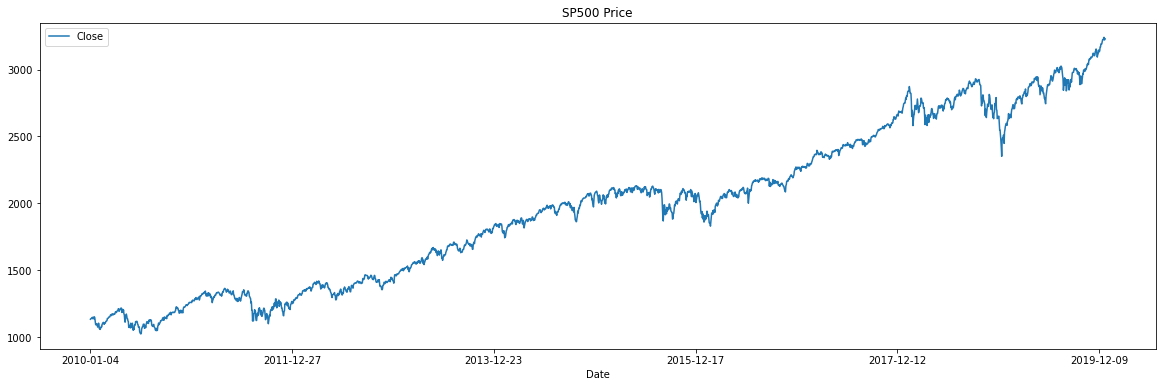

In [4]:
# remove unecessary columns
data = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

data.plot(figsize=(20, 6), title='SP500 Price')

In [5]:
def gen_nan_arr(size):
    arr, arr[:] = np.zeros(size), np.nan
    return arr

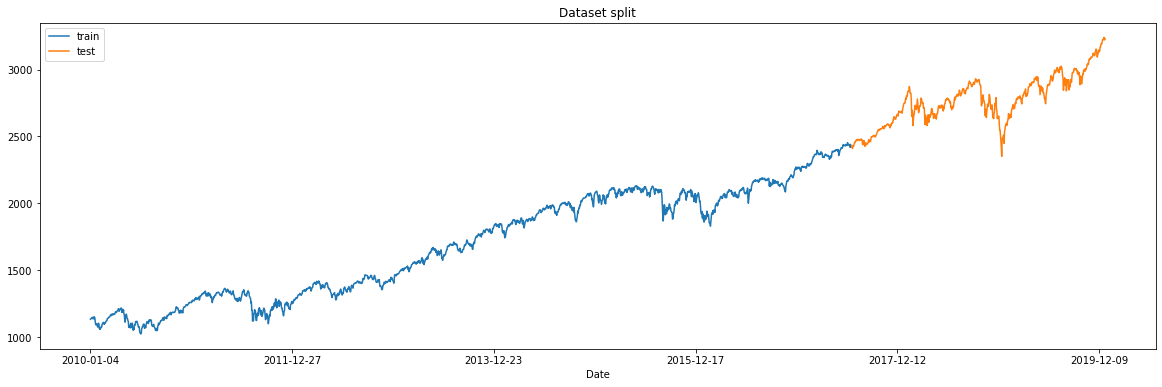

In [6]:
# get split train and test dataset

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data.values, shuffle=False)
data['train'] = np.append(train_data, gen_nan_arr(test_data.size))
data['test'] = np.append(gen_nan_arr(train_data.size), test_data)
data[['train', 'test']].plot(figsize=(20, 6), title='Dataset split')

In [7]:
# run KPSS and ADF test to find the differencing term

kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)

n_diffs = max(adf_diffs, kpss_diffs)

print(f'Estimated differencing term: {n_diffs}')

Estimated differencing term: 1


In [8]:
# fit model

model = pm.auto_arima(train_data, 
                      d=n_diffs,
                      trace=True,
                      error_action='ignore',  # don't want to know if an order does not work
                      suppress_warnings=True,  # don't want convergence warnings
                      stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=15504.842, BIC=15538.096, Time=1.415 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15511.669, BIC=15522.753, Time=0.032 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=15511.249, BIC=15527.876, Time=0.070 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15511.273, BIC=15527.899, Time=0.160 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=15513.714, BIC=15519.256, Time=0.024 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=15506.076, BIC=15533.787, Time=0.906 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=15512.699, BIC=15540.410, Time=0.802 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=15506.700, BIC=15545.495, Time=2.171 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=15506.701, BIC=15545.496, Time=2.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15510.892, BIC=15533.061, Time=0.610 seconds
Fit ARIMA(1,1,3)

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1887
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7746.421
Date:                Sun, 28 Jun 2020   AIC                          15504.842
Time:                        02:12:19   BIC                          15538.096
Sample:                             0   HQIC                         15517.089
                               - 1887                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0687      0.035      1.964      0.050       0.000       0.137
ar.L1          0.0730      0.108      0.679      0.497      -0.138       0.284
ar.L2          0.8276      0.099      8.378      0.000       0.634       1.021
ma.L1         -0.1185      0.113     -1.046      0.295      -0.340       0.103
ma.L2         -0.8271      0.107     -7.715      0.000      -1.037      -0.617
sigma2       216.3130      4.687     46.148      0.000     207.126     225.500
===================================================================================
Ljung-Box (Q):                       64.11   Jarque-Bera (JB):               749.94
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

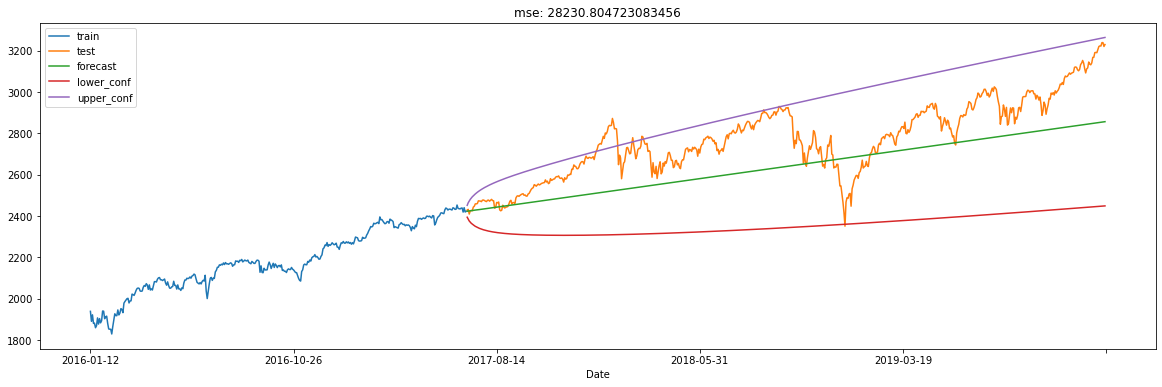

In [10]:
# make forecast 

forecast, conf_int = model.predict(test_data.size, return_conf_int=True)

mse = mean_squared_error(test_data, forecast)

data['forecast'] = np.append(gen_nan_arr(train_data.size), forecast)

data['lower_conf'] = np.append(gen_nan_arr(train_data.size), [i[0] for i in conf_int])
data['upper_conf'] = np.append(gen_nan_arr(train_data.size), [i[1] for i in conf_int])

data[['train', 'test', 'forecast', 'lower_conf', 'upper_conf']][-1000:].plot(figsize=(20, 6), title=f'mse: {mse}')

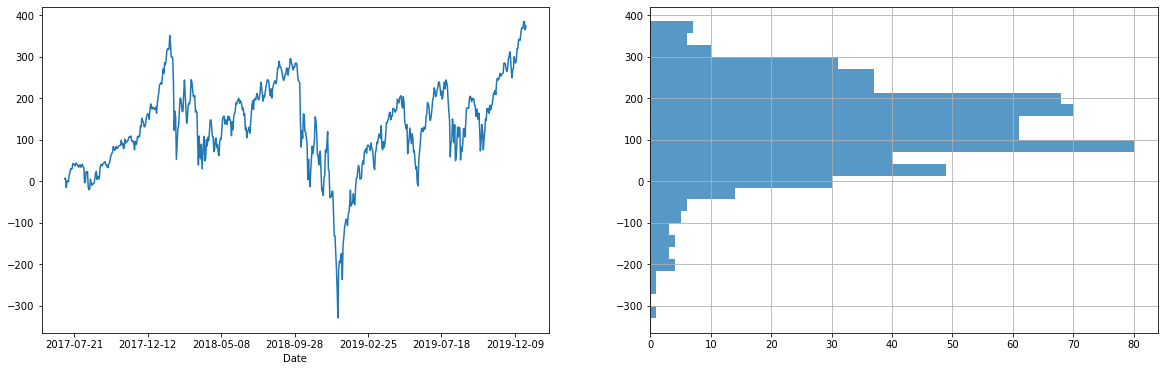

In [11]:
# calculate error along the axis

data['error'] = np.append(gen_nan_arr(train_data.size), np.reshape(test_data, test_data.size)-forecast)

fig, error_axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# data[['error']].plot(figsize=(20, 6))
# data[['error']].hist(figsize=(20, 6), alpha=0.75, bins=25)

data['error'].plot(ax=error_axes[0])
data['error'].hist(ax=error_axes[1], alpha=0.75, bins=25, orientation='horizontal')